# Eval code

In [10]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd

# Load the TensorBoard event file
event_path = r"runs\ALE\SpaceInvaders-v5__ppo_clean_rl__1__20241222_113601\events.out.tfevents.1734863766.DESKTOP-O5Q6R7F.17768.0"
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# Get list of available tags/metrics
tags = event_acc.Tags()

# Create dictionary to store metrics
metrics = {}

# Extract metrics into dictionary
for tag in tags['scalars']:
    events = event_acc.Scalars(tag)
    metrics[tag] = pd.DataFrame(events)[['step', 'value']]
    metrics[tag] = metrics[tag].set_index('step')
    metrics[tag].columns = [tag]

# Combine all metrics into single dataframe by joining on step index
df = pd.DataFrame()
for metric_df in metrics.values():
    df = df.join(metric_df, how='outer')

print(f"df.shape: {df.shape}")
df.head(10)

df.shape: (100, 3)


,eval/episodic_return,eval/episodic_length,eval/episodic_time
step,,,
0,500.0,885.0,1.696431
1,485.0,944.0,1.517179
2,270.0,744.0,1.085669
3,375.0,811.0,1.146262
4,400.0,792.0,1.103187
5,275.0,645.0,0.951736
6,365.0,722.0,1.114528
7,240.0,508.0,0.777512
8,575.0,1181.0,1.911992


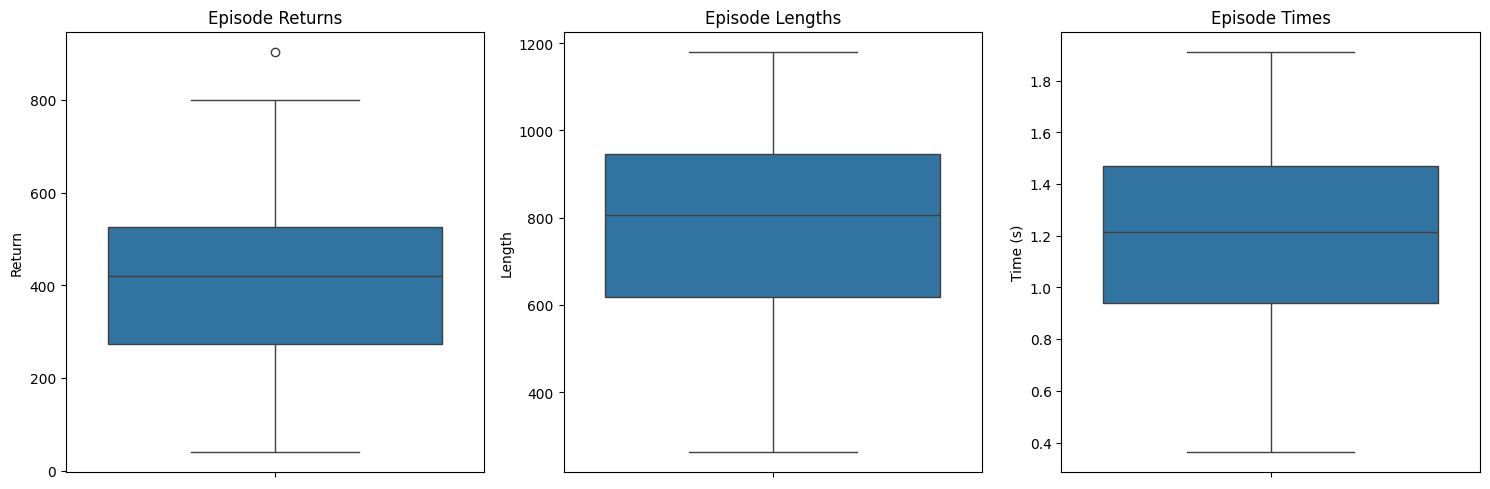

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create box plots for each metric
sns.boxplot(y=df['eval/episodic_return'].dropna(), ax=axes[0])
axes[0].set_title('Episode Returns')
axes[0].set_ylabel('Return')

sns.boxplot(y=df['eval/episodic_length'].dropna(), ax=axes[1]) 
axes[1].set_title('Episode Lengths')
axes[1].set_ylabel('Length')

sns.boxplot(y=df['eval/episodic_time'].dropna(), ax=axes[2])
axes[2].set_title('Episode Times')
axes[2].set_ylabel('Time (s)')

plt.tight_layout()
plt.show()


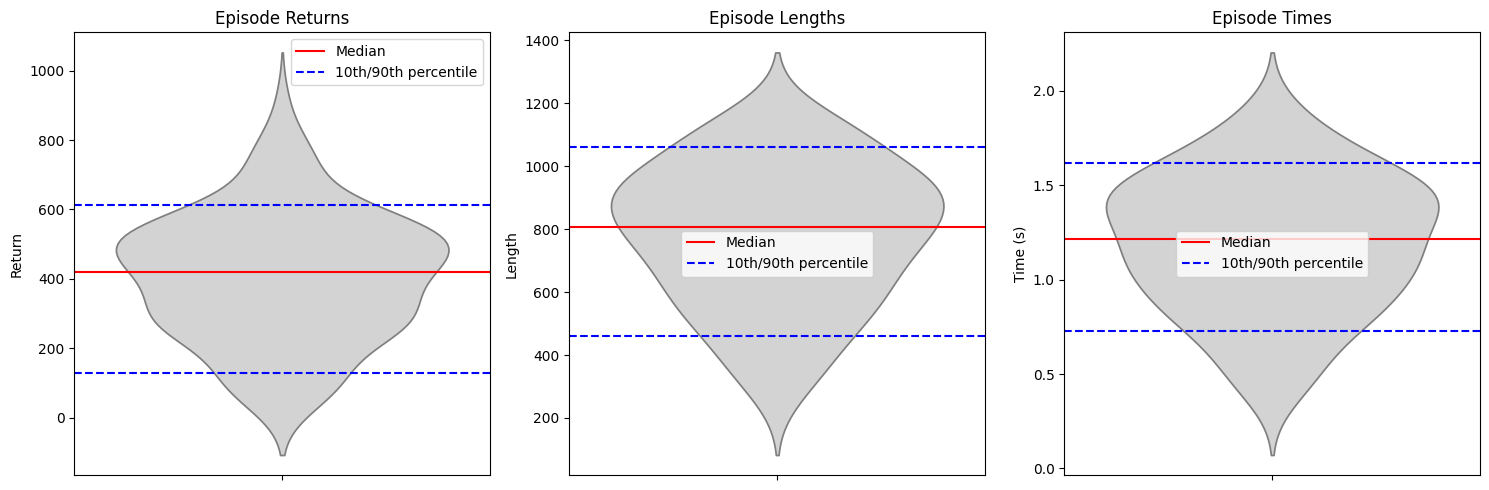

In [14]:
# Create figure with subplots for median/percentile plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Calculate percentiles for each metric
metrics = ['eval/episodic_return', 'eval/episodic_length', 'eval/episodic_time']
titles = ['Episode Returns', 'Episode Lengths', 'Episode Times'] 
ylabels = ['Return', 'Length', 'Time (s)']

for i, (metric, title, ylabel) in enumerate(zip(metrics, titles, ylabels)):
    data = df[metric].dropna()
    
    # Calculate statistics
    median = np.median(data)
    p10 = np.percentile(data, 10)
    p90 = np.percentile(data, 90)
    
    # Create violin plot
    sns.violinplot(y=data, ax=axes[i], inner=None, color='lightgray')
    
    # Add lines for median and percentiles
    axes[i].axhline(y=median, color='red', linestyle='-', label='Median')
    axes[i].axhline(y=p10, color='blue', linestyle='--', label='10th/90th percentile')
    axes[i].axhline(y=p90, color='blue', linestyle='--')
    
    axes[i].set_title(title)
    axes[i].set_ylabel(ylabel)
    axes[i].legend()

plt.tight_layout()
plt.show()


In [12]:

import numpy as np
import scipy.stats as stats

def aggregate_evaluation_metrics(episode_returns, episode_lengths):
    """
    Aggregate evaluation metrics from evaluation episodes in meaningful ways.
    
    Args:
        episode_returns: List of returns from each episode
        episode_lengths: List of episode lengths
    """
    metrics = {}
    
    # Basic statistics
    metrics['mean_return'] = np.mean(episode_returns)
    metrics['median_return'] = np.median(episode_returns)
    metrics['std_return'] = np.std(episode_returns)
    
    # Robustness metrics
    metrics['cv'] = metrics['std_return'] / metrics['mean_return']
    metrics['iqr'] = np.percentile(episode_returns, 75) - np.percentile(episode_returns, 25)
    metrics['min_return'] = np.min(episode_returns)
    metrics['max_return'] = np.max(episode_returns)
    
    # Confidence intervals (assuming normal distribution)
    ci = stats.t.interval(0.95, len(episode_returns)-1,
                         loc=metrics['mean_return'],
                         scale=stats.sem(episode_returns))
    metrics['ci_lower'], metrics['ci_upper'] = ci
    
    # Episode length metrics
    metrics['mean_episode_length'] = np.mean(episode_lengths)
    metrics['median_episode_length'] = np.median(episode_lengths)
    metrics['std_episode_length'] = np.std(episode_lengths)
    
    return metrics

# Extract evaluation metrics from dataframe
eval_returns = df['eval/episodic_return'].dropna().values
eval_lengths = df['eval/episodic_length'].dropna().values

# Calculate aggregate metrics
metrics = aggregate_evaluation_metrics(eval_returns, eval_lengths)

# Print results
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")


mean_return: 407.25
median_return: 420.00
std_return: 184.06
cv: 0.45
iqr: 251.25
min_return: 40.00
max_return: 905.00
ci_lower: 370.54
ci_upper: 443.96
mean_episode_length: 779.03
median_episode_length: 805.50
std_episode_length: 225.98
